# Kaggle 1등 수상자 코드 아이디어

- 정확도가 50% 나오는데, 뭔가 이상하다.


In [7]:
# 모듈 불러 오기
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
import re

import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk import word_tokenize

from collections import Counter
import math

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Embedding, Dense, Dropout
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [8]:
# 경로 설정
root_path = "/content/drive/My Drive/멀티캠퍼스/[혁신성장] 인공지능 자연어처리 기반/[강의]/조성현 강사님"
data_path = f"{root_path}/dataset"

In [9]:
# 데이터 로드 및 원본 보존
df_raw = pd.read_csv(f"{data_path}/4-1.labeledTrainData.tsv",
                     header=0,
                     delimiter='\t',
                     quoting=3)
display(df_raw)

,id,sentiment,review
0,"""5814_8""",1,"""With all this stuff going down at the moment ..."
1,"""2381_9""",1,"""\""The Classic War of the Worlds\"" by Timothy ..."
2,"""7759_3""",0,"""The film starts with a manager (Nicholas Bell..."
3,"""3630_4""",0,"""It must be assumed that those who praised thi..."
4,"""9495_8""",1,"""Superbly trashy and wondrously unpretentious ..."
...,...,...,...
24995,"""3453_3""",0,"""It seems like more consideration has gone int..."
24996,"""5064_1""",0,"""I don't believe they made this film. Complete..."
24997,"""10905_3""",0,"""Guy is a loser. Can't get girls, needs to bui..."
24998,"""10194_3""",0,"""This 30 minute documentary Buñuel made in the..."


## _1_. 전처리

- 텍스트 기본 전처리
    - HTML 태그 제거
    - 영어 제외 변환
    - 소문자화
    - 불용어 제거
    - 포터 스테밍 어간 추출
- MI Score 상위 50%

In [10]:
def clean_text(x):
    x = BeautifulSoup(x, 'lxml').get_text() # HTML 태그 제거
    x = re.sub("[^a-zA-Z]", " ", x) # 영어 제외 바꾸기
    x = x.lower() # 소문자
    x = [w for w in x.split() if not w in stopwords.words('english')] # 불용어 제거
    x = [PorterStemmer().stem(word) for word in x] # 포터 스테밍으로 어간 추출
    return " ".join(x)

In [11]:
%%time
df_raw['text'] = df_raw['review'].apply(lambda x: clean_text(x))

CPU times: user 8min 37s, sys: 51.2 s, total: 9min 28s
Wall time: 9min 28s


In [12]:
df = df_raw[['text', 'sentiment']]
display(df)

,text,sentiment
0,stuff go moment mj start listen music watch od...,1
1,classic war world timothi hine entertain film ...,1
2,film start manag nichola bell give welcom inve...,0
3,must assum prais film greatest film opera ever...,0
4,superbl trashi wondrous unpretenti exploit hoo...,1
...,...,...
24995,seem like consider gone imdb review film went ...,0
24996,believ made film complet unnecessari first fil...,0
24997,guy loser get girl need build pick stronger su...,0
24998,minut documentari bu uel made earli one spain ...,0


In [13]:
# 긍정 sentiment와 부정 sentiment로 나누기
df_pos = df[df['sentiment'] == 1]
df_neg = df[df['sentiment'] == 0]

### 어휘집 생성 : MI Score 계산

- `counter` 방식 맞는지 확인

In [14]:
def build_vocab(df):
    vocabulary = Counter()

    for text in df['text']:
        for word in list(set(word_tokenize(text))): # set으로 중복 단어 제거
            vocabulary[word] += 1
    
    return vocabulary.most_common()

In [15]:
def calc_MI(pos_df, neg_df):

    pos_vocab = build_vocab(pos_df)
    neg_vocab = build_vocab(neg_df)
    
    merge_vocab = {}
    for k, v in pos_vocab:
        merge_vocab[k] = [v, 0]
    for k, v in neg_vocab:
        if k in merge_vocab:
            merge_vocab[k][1] = v
        else:
            merge_vocab[k] = [0, v]
    
    # MI 계산
    clip = 0.00001
    for k, v in merge_vocab.items():
        merge_vocab[k] = (v[0] / (len(pos_df)+len(neg_df))) * math.log(2*(v[0]+clip) / (v[0] + v[1])) + \
                        (v[1] / (len(pos_df)+len(neg_df))) * math.log(2*(v[1]+clip) / (v[0] + v[1]))
    
    return {k:v for k, v in sorted(merge_vocab.items(), key=lambda x:x[1], reverse=True)}

In [16]:
# 어휘집 생성
%%time
vocabulary = calc_MI(df_pos, df_neg)
print(f"총 어휘집 크기: {len(vocabulary)}")

총 어휘집 크기: 50593
CPU times: user 12.9 s, sys: 21 ms, total: 12.9 s
Wall time: 12.9 s


In [18]:
# 가장 흔한 단어 20개 확인
print("상위 20개 단어 확인")
print(list(vocabulary.keys())[:20])

상위 20개 단어 확인
['worst', 'bad', 'wast', 'aw', 'excel', 'great', 'stupid', 'bore', 'terribl', 'wors', 'horribl', 'beauti', 'love', 'perfect', 'poor', 'crap', 'noth', 'poorli', 'suppos', 'lame']


In [19]:
# 상위 50퍼센트만 남기기 + OOV 버리기
word2idx = {k:i+1 for i, (k, v) in enumerate(vocabulary.items()) if i <= len(vocabulary)//2}
# word2idx['OOV'] = 0
idx2word = {v:k for k, v in word2idx.items()}

### 시퀀스 토큰화

In [ ]:
# 토크나이징
print(f"기존 문장 개수: {len(df['text'])}")

tokens = []

for idx, text in enumerate(df['text']):
    temp = []
    delete_indices = []

    for word in text.split():
        try:
            temp.append(word2idx[word])
        except KeyError: # OOV
            continue 
    
    if len(temp) > 0:
        tokens.append(temp)
    else:
        delete_indices.append(idx)

print(f"OOV 없는 문장으로만 남긴 개수: {len(tokens)}")
print(f"삭제해야 할 문장 인덱스: {delete_indices}")

기존 문장 개수: 25000
OOV 없는 문장으로만 남긴 개수: 25000
삭제해야 할 문장 인덱스: []


### 패딩

In [ ]:
# 문장 길이 체크
def check_len(threshold, sentences):
    cnt = 0
    for sent in sentences:
        if len(sent) <= threshold:
            cnt += 1
    
    return f'전체 문장 중 길이가 {threshold} 이하인 샘플의 비율: {(cnt/len(sentences))*100}'

for i in range(10, 300, 10):
    print(check_len(i, tokens))

전체 문장 중 길이가 10 이하인 샘플의 비율: 0.132
전체 문장 중 길이가 20 이하인 샘플의 비율: 2.084
전체 문장 중 길이가 30 이하인 샘플의 비율: 6.672000000000001
전체 문장 중 길이가 40 이하인 샘플의 비율: 11.856
전체 문장 중 길이가 50 이하인 샘플의 비율: 22.567999999999998
전체 문장 중 길이가 60 이하인 샘플의 비율: 37.303999999999995
전체 문장 중 길이가 70 이하인 샘플의 비율: 48.46
전체 문장 중 길이가 80 이하인 샘플의 비율: 56.912
전체 문장 중 길이가 90 이하인 샘플의 비율: 63.188
전체 문장 중 길이가 100 이하인 샘플의 비율: 68.328
전체 문장 중 길이가 110 이하인 샘플의 비율: 72.432
전체 문장 중 길이가 120 이하인 샘플의 비율: 75.976
전체 문장 중 길이가 130 이하인 샘플의 비율: 78.996
전체 문장 중 길이가 140 이하인 샘플의 비율: 81.636
전체 문장 중 길이가 150 이하인 샘플의 비율: 83.804
전체 문장 중 길이가 160 이하인 샘플의 비율: 85.804
전체 문장 중 길이가 170 이하인 샘플의 비율: 87.508
전체 문장 중 길이가 180 이하인 샘플의 비율: 88.872
전체 문장 중 길이가 190 이하인 샘플의 비율: 90.13600000000001
전체 문장 중 길이가 200 이하인 샘플의 비율: 91.316
전체 문장 중 길이가 210 이하인 샘플의 비율: 92.32000000000001
전체 문장 중 길이가 220 이하인 샘플의 비율: 93.244
전체 문장 중 길이가 230 이하인 샘플의 비율: 93.988
전체 문장 중 길이가 240 이하인 샘플의 비율: 94.692
전체 문장 중 길이가 250 이하인 샘플의 비율: 95.204
전체 문장 중 길이가 260 이하인 샘플의 비율: 95.776
전체 문장 중 길이가 270 이하인 샘플의 비율: 96.22
전체 문장 중 길이가

In [ ]:
# 문장 패딩
MAX_LENGTH = int(input('문장 최대 길이 설정: '))

X_train = pad_sequences(tokens, 
                        maxlen=MAX_LENGTH,
                        padding='post',
                        truncating='post')

X_train = np.array(X_train)
print(f"패딩 후 train data: {X_train.shape}")

문장 최대 길이 설정: 200
패딩 후 train data: (25000, 200)


In [ ]:
# 문장 확인
print(X_train[0])
print(f"샘플 문장 길이: {len(X_train[0])}")

[ 1848   405  1232  1862   600   358   730  9191   623   730   730  1941
   291   277   743  1230  3309   102 15403   715   291   501 15947   335
  1941  8890  8587  8890  4602  9003   439   405  1528   636  1541   556
   132  1994  1862  1349  6389    60   332  1994  6289     2 15371   573
   531  1045  1908  8808    50   157   472  1862  1178   405   677   527
     8   415   389  1862 13527   501   202  1862  1991   213   233   610
  1991    99   715   676   228  4602  9003   526  1986   600    24   748
  2378 15220  1916 15296   160  6289  3683   277  1862   750     2  1837
  1862  4905  1916 15296  5067   277  3846  8726  6289  9160  3275   291
   677  1862   358  5823   197   472  1862  6183  2693  8898   363 15251
 13643 15220    60  1784  3230 14260  8592  4911  9003     2 15220 14021
  1784   677   622  2304   387   363   103    27   164  1402  1616   327
   681   202  3846   472  1862  3806  1422  3846  2799  3971    71  8034
  9186  1994  5825  1862  9908   202  8424  1908  8

### 데이터 저장

In [ ]:
# 라벨 가져오기
label = df['sentiment']
label = np.array(y_train)
print(f"train label: {label.shape}")

train label: (25000,)


In [ ]:
# 전처리 완료된 데이터 저장
input_out_path = f"{data_path}/popcorn_input_mydata.npy"
label_out_path = f"{data_path}/popcorn_label_mydata.npy"

np.save(open(input_out_path, 'wb'), X_train)
np.save(open(label_out_path, 'wb'), y_train)
df.to_csv(f"{data_path}/popcorn_clean_mydata.csv", index=False, encoding='utf-8-sig')

## _2_. 모델링

In [20]:
# 데이터 로드
train_features = np.load(open(f"{data_path}/popcorn_input_mydata.npy", 'rb'))
train_labels = np.load(open(f"{data_path}/popcorn_label_mydata.npy", 'rb'))

In [21]:
# 원래 문장으로 바꾸기
sequences = []
for vector in train_features:
    temp = []
    for x in vector:
        try:
            temp.append(idx2word[x])
        except KeyError:
            pass

    sequences.append(temp)

### TF-IDF

In [22]:
corpus = [" ".join(sequence) for sequence in sequences ] # 
print(corpus[:3])

['stuff go moment mj start music watch odd documentari watch watch moonwalk mayb want get certain insight guy thought realli mayb make mind innoc moonwalk part biographi part featur film rememb go see cinema origin releas subtl messag mj feel toward also obviou messag drug bad kay visual impress cours michael jackson unless remot like mj anyway go hate find bore may call mj consent make movi mj fan would say made fan true realli nice actual featur film bit final start minut smooth crimin sequenc joe pesci power drug lord want mj dead bad beyond mj nah joe pesci rant want peopl know drug etc dunno mayb hate mj music lot thing like mj turn car robot whole speed demon sequenc also director must patienc saint came film bad sequenc usual director hate work kid let whole bunch perform complex danc scene bottom line movi peopl like mj anoth think peopl stay away tri give wholesom messag iron mj bestest movi girl michael jackson truli talent peopl ever well attent gave hmmm well know peopl dif

In [25]:
vectorizer = TfidfVectorizer().fit(corpus)
tfidf_vec = vectorizer.transform(corpus).toarray()
print(f"TF-IDF 행렬: {tfidf_vec.shape}")
print("========== 어휘집 내 단어 샘플 20개 확인 ==========")
print(list(vectorizer.vocabulary_)[:20])

TF-IDF 행렬: (25000, 24530)
========== 어휘집 내 단어 샘플 20개 확인 ==========
['stuff', 'go', 'moment', 'mj', 'start', 'music', 'watch', 'odd', 'documentari', 'moonwalk', 'mayb', 'want', 'get', 'certain', 'insight', 'guy', 'thought', 'realli', 'make', 'mind']


### Doc2Vec


In [26]:
# Doc2Vec 파라미터 설정
doc2vec_features = int(input('Doc2Vec 임베딩 차원 설정: '))

# 사용할/로드할 모델 경로 설정
model_path = f"{data_path}/IMDB_{doc2vec_features}features.doc2vec"

try:
    doc_model = Doc2Vec.load(model_path)
except: # 저장된 모델 없는 경우
    documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(sequences)]
    doc_model = Doc2Vec(vector_size=doc2vec_features,
                        alpha=0.005,
                        min_alpha=0.0001,
                        min_count=1,
                        workers=4,
                        dm=1)
    doc_model.build_vocab(documents)
    doc_model.train(documents, total_examples=doc_model.corpus_count, epochs=10)
    doc_model.save(model_path)

Doc2Vec 임베딩 차원 설정: 400


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:254: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [27]:
# 모델 확인
keys = list(doc_model.wv.vocab.keys())
print(f"단어 개수: {len(keys)}")
print("========= 샘플 확인 =========")
print(keys[:20])

단어 개수: 24539
========= 샘플 확인 =========
['stuff', 'go', 'moment', 'mj', 'start', 'music', 'watch', 'odd', 'documentari', 'moonwalk', 'mayb', 'want', 'get', 'certain', 'insight', 'guy', 'thought', 'realli', 'make', 'mind']


In [29]:
# Doc2Vec 벡터 생성
doc2vec_vec = [doc_model.docvecs[i] for i in range(len(sequences))]
doc2vec_vec = np.array(doc2vec_vec)
print(doc2vec_vec.shape)

(25000, 400)


### 결합 모델

In [30]:
X_train_tf, X_test_tf, X_train_doc, X_test_doc, y_train, y_test = train_test_split(tfidf_vec, doc2vec_vec, train_labels,
                                                                                   test_size=0.2,
                                                                                   random_state=42)
print(f"TFIDF: train {X_train_tf.shape}, test {X_test_tf.shape}")
print(f"Doc2Vec: train {X_train_doc.shape}, test {X_test_doc.shape}")
print(f"label: train {y_train.shape}, test {y_test.shape}")

TFIDF: train (20000, 24530), test (5000, 24530)
Doc2Vec: train (20000, 400), test (5000, 400)
label: train (20000,), test (5000,)


In [33]:
K.clear_session()

# FFN 네트워크 설정
X_input_1 = Input(batch_shape=(None, tfidf_vec.shape[1])) # TFIDF 입력
X_dense_1 = Dense(64, activation='linear')(X_input_1) # 선형 projection
X_input_2 = Input(batch_shape=(None, doc2vec_vec.shape[1])) # Doc2Vec 입력
X_dense_2 = Dense(64, activation='linear')(X_input_2)
X_concat = Concatenate()([X_dense_1, X_dense_2])
y_output = Dense(1, activation='sigmoid')(X_concat)

# 모델 구성
model = Model([X_input_1, X_input_2], y_output)
model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.001))
print("====== 전체 모델 구조 확인 ======")
print(model.summary())

====== 전체 모델 구조 확인 ======
Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 24530)]      0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 400)]        0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 64)           1569984     input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 64)           25664       input_2[0][0]                    
_____________________________________________________________

In [34]:
# 학습
es = EarlyStopping(monitor='val_loss', patience=10, verbose=1)
hist = model.fit([X_train_tf, X_train_doc], y_train,
                 epochs=300,
                 batch_size=300,
                 callbacks=[es],
                 validation_data=([X_test_tf, X_test_doc], y_test))

Epoch 1/300
67/67 [==============================] - 1s 19ms/step - loss: 0.5677 - val_loss: 0.4483
Epoch 2/300
67/67 [==============================] - 1s 15ms/step - loss: 0.3626 - val_loss: 0.3215
Epoch 3/300
67/67 [==============================] - 1s 15ms/step - loss: 0.2580 - val_loss: 0.2696
Epoch 4/300
67/67 [==============================] - 1s 15ms/step - loss: 0.2028 - val_loss: 0.2472
Epoch 5/300
67/67 [==============================] - 1s 15ms/step - loss: 0.1679 - val_loss: 0.2389
Epoch 6/300
67/67 [==============================] - 1s 15ms/step - loss: 0.1427 - val_loss: 0.2368
Epoch 7/300
67/67 [==============================] - 1s 15ms/step - loss: 0.1228 - val_loss: 0.2394
Epoch 8/300
67/67 [==============================] - 1s 15ms/step - loss: 0.1069 - val_loss: 0.2447
Epoch 9/300
67/67 [==============================] - 1s 15ms/step - loss: 0.0937 - val_loss: 0.2516
Epoch 10/300
67/67 [==============================] - 1s 15ms/step - loss: 0.0826 - val_loss: 0.2595

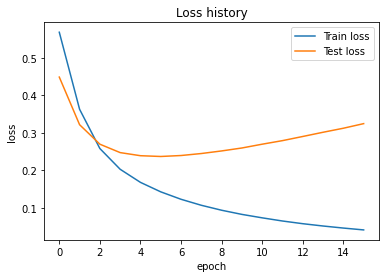

In [35]:
# loss 시각화
plt.plot(hist.history['loss'], label='Train loss')
plt.plot(hist.history['val_loss'], label = 'Test loss')
plt.legend()
plt.title("Loss history")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()

In [36]:
# 예측 및 결과 확인
y_pred = model.predict([X_test_tf, X_test_doc])
y_pred = np.where(y_pred > 0.5, 1, 0)
accuracy = (y_test == y_pred).mean()
print(f"Test Accuracy: {accuracy}")

Test Accuracy: 0.50002584
